In [1]:
from ldm.models.diffusion import options

options.LDM_DISTILLATION_ONLY = True

from threestudio.models.guidance import zero123_guidance
from omegaconf import OmegaConf

guidance_cfg = dict(
    pretrained_model_name_or_path= "/svl/u/ksarge/nextnvs/zeronvs.ckpt",
    pretrained_config= "/svl/u/ksarge/nextnvs/zeronvs_config.yaml",
    guidance_scale= 7.5,
    cond_image_path = "/svl/u/ksarge/nextnvs/motorcycle.png",  # unused
    min_step_percent=[0,.75,.02,1000],
    max_step_percent=[1000, 0.98, 0.025, 2500],
    vram_O=False
)

guidance = zero123_guidance.Zero123Guidance(OmegaConf.create(guidance_cfg))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/svl/u/stian/mamba_envs/zeronvs/lib/python3.8/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/svl/u/stian/mamba_envs/zeronvs/lib/python3.8/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/svl/u/stian/mamba_envs/zeronvs/lib/python3.8/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_21m_224 in registry with controlnet_aux.se

SDS distillation only, disabling some functionality...
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Loaded Zero123!


In [2]:
from PIL import Image
import numpy as np
import torch

cond_image_pil = Image.open("motorcycle.png").convert("RGB")
print(cond_image_pil.size)
cond_image = torch.from_numpy(np.array(cond_image_pil)).cuda() / 255.

c_crossattn, c_concat = guidance.get_img_embeds(
    cond_image.permute((2, 0, 1))[None])

cond_camera = np.eye(4)  # identity camera pose
target_camera = cond_camera.copy()
target_camera[:3, -1] = np.array([.125, .125, .125])  # perturb the cond pose

target_camera = torch.from_numpy(target_camera[None]).cuda().to(torch.float32)
cond_camera = torch.from_numpy(cond_camera[None]).cuda().to(torch.float32)

(256, 256)


In [3]:
camera_batch = {
    "target_cam2world": target_camera,
    "cond_cam2world": cond_camera,
    "fov_deg": torch.from_numpy(np.array([45.0])).cuda().to(torch.float32)
}

guidance.cfg.precomputed_scale=.7
cond = guidance.get_cond_from_known_camera(
    camera_batch,
    c_crossattn=c_crossattn,
    c_concat=c_concat,
    # precomputed_scale=.7,
)

In [4]:
novel_view = guidance.gen_from_cond(cond)
novel_view_pil = Image.fromarray(np.clip(novel_view[0]*255, 0, 255).astype(np.uint8))

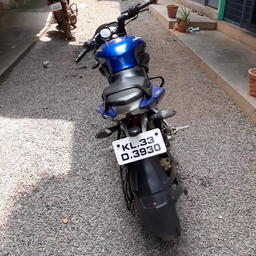

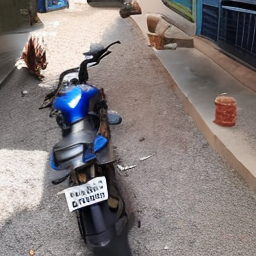

In [5]:
display(cond_image_pil)
display(novel_view_pil)

In [30]:
def perform_nvs(cond_image_pil, target_camera, cond_camera=None, scale=0.9):
    cond_image_pil = cond_image_pil.resize((256, 256))
    cond_image = torch.from_numpy(np.array(cond_image_pil)).cuda() / 255.
    
    c_crossattn, c_concat = guidance.get_img_embeds(
        cond_image.permute((2, 0, 1))[None])
    if cond_camera is None:
        cond_camera = np.eye(4)  # identity camera pose
    target_camera = torch.from_numpy(target_camera[None]).cuda().to(torch.float32)
    cond_camera = torch.from_numpy(cond_camera[None]).cuda().to(torch.float32)

    camera_batch = {
        "target_cam2world": target_camera,
        "cond_cam2world": cond_camera,
        "fov_deg": torch.from_numpy(np.array([68.0])).cuda().to(torch.float32)
    }
    
    guidance.cfg.precomputed_scale=scale
    cond = guidance.get_cond_from_known_camera(
        camera_batch,
        c_crossattn=c_crossattn,
        c_concat=c_concat,
        # precomputed_scale=.7,
    )
    novel_view = guidance.gen_from_cond(cond, scale=7.5, ddim_steps=250, ddim_eta=0.5) #play with eta, try increasing guidance
    novel_view_pil = Image.fromarray(np.clip(novel_view[0]*255, 0, 255).astype(np.uint8))
    return novel_view_pil

In [7]:
view_1 = np.eye(4)
view_1[:3, -1] = np.array([.125, .125, .125])  # perturb the cond pose

view_2 = np.eye(4)
view_2[:3, -1] = np.array([0, 0, -.125])  # perturb the cond pose

novel_view_1 = perform_nvs("motorcycle.png", view_1)
display(novel_view_1)
novel_view_2 = perform_nvs("motorcycle.png", view_2)
display(novel_view_2)

AttributeError: 'str' object has no attribute 'resize'

Original


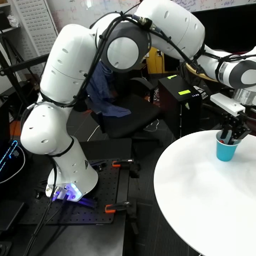

Transform  [[-0.99556414  0.05498319 -0.07634723  0.25081285]
 [-0.04454929  0.43925247  0.89725839 -0.59746929]
 [ 0.08286984  0.89667949 -0.43485455  0.8402273 ]
 [ 0.          0.          0.          1.        ]]


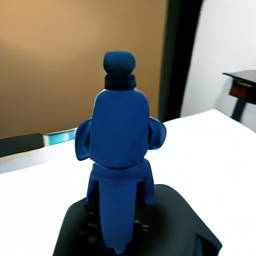

Cam 2 Original


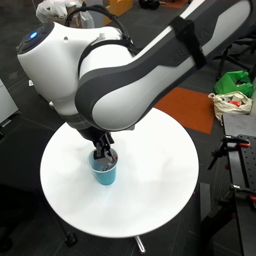

Transform  [[ 1.     0.     0.     0.3  ]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.    -0.125]
 [ 0.     0.     0.     1.   ]]


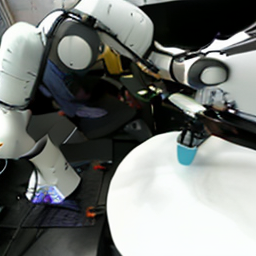

In [35]:
image_path = "/viscam/projects/vipl/MP4/image_2_1.png"
view_1 = np.eye(4)
view_1[:3, -1] = np.array([-.3, 0, -0.15])  # perturb the cond pose

def compute_relative_transform(cam_1, cam_2):
    # Invert cam_1 transformation
    cam_1_inv = np.linalg.inv(cam_1)
    
    # Compute relative transformation from cam_1 to cam_2
    relative_transform = np.dot(cam_1_inv, cam_2)
    
    return relative_transform


cam_1_ext = np.array([[ 0.98721178, -0.08898878, -0.13226451,  0.33437361],
       [ 0.04731922, -0.62871677,  0.77619335, -0.46365509],
       [-0.15222942, -0.77252587, -0.61646572,  0.64372253],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
cam_2_ext = np.array([[-0.9776275 , -0.20174358,  0.05953149,  0.40901957],
       [-0.14093838,  0.41817256, -0.89736731,  0.57553184],
       [ 0.15614365, -0.88568123, -0.43725041,  0.44278209],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

cam_1 = np.array([[1, 0, 0, 1],
                  [0, 1, 0, 2],
                  [0, 0, 1, 3],
                  [0, 0, 0, 1]])

cam_2 = np.array([[0, -1, 0, 4],
                  [1, 0, 0, 5],
                  [0, 0, 1, 6],
                  [0, 0, 0, 1]])

# print(compute_relative_transform(cam_1, cam_2))

view_1 = compute_relative_transform(cam_2_ext, cam_1_ext)
# view_1 = compute_relative_transform(cam_1_ext, cam_2_ext)

def center_crop(img, w, h):
    img_width, img_height = img.size
    left, right = (img_width - w) / 2, (img_width + w) / 2
    top, bottom = (img_height - h) / 2, (img_height + h) / 2
    left, top = round(max(0, left)), round(max(0, top))
    right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
    return img.crop((left, top, right, bottom))

view_2 = np.eye(4)
view_2[:3, -1] = np.array([0.3, 0, -0.125])  # perturb the cond pose
orig_image = center_crop(Image.open(image_path).convert("RGB"), 720, 720).resize((256, 256))
print("Original")
display(orig_image)
novel_view_1 = perform_nvs(orig_image, cam_2_ext, cond_camera=cam_1_ext)
print("Transform ", view_1)

display(novel_view_1)

print("Cam 2 Original")
display(center_crop(Image.open("/viscam/projects/vipl/MP4/image_1_1.png").convert("RGB"), 720, 720).resize((256, 256)))
novel_view_2 = perform_nvs(orig_image, view_2)
print("Transform ", view_2)
display(novel_view_2)

Original


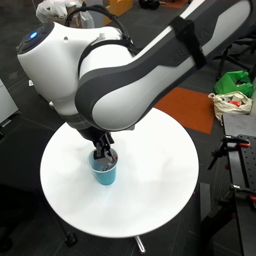

Transform  [[1.    0.    0.    0.5  ]
 [0.    1.    0.    0.125]
 [0.    0.    1.    0.125]
 [0.    0.    0.    1.   ]]


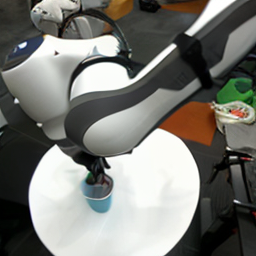

Transform  [[ 1.     0.     0.     0.   ]
 [ 0.     1.     0.     0.125]
 [ 0.     0.     1.    -0.125]
 [ 0.     0.     0.     1.   ]]


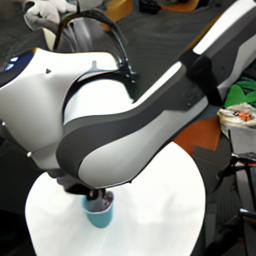

In [12]:
image_path = "/viscam/projects/vipl/MP4/image_1_1.png"
view_1 = np.eye(4)
view_1[:3, -1] = np.array([.5, .125, .125])  # perturb the cond pose

view_2 = np.eye(4)
view_2[:3, -1] = np.array([0, 0.125, -.125])  # perturb the cond pose
orig_image = center_crop(Image.open(image_path).convert("RGB"), 720, 720).resize((256, 256))
print("Original")
display(orig_image)
novel_view_1 = perform_nvs(orig_image, view_2, scale=1.3)
print("Transform ", view_1)
display(novel_view_1)
novel_view_2 = perform_nvs(orig_image, view_2, scale=0.7)
print("Transform ", view_2)
display(novel_view_2)

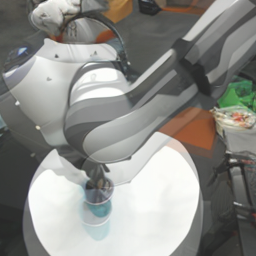

In [10]:
# overlay novel views 1 and 2
def alpha_comp(a, b):
    a = a.convert("RGBA")
    b = b.convert("RGBA")
    a.putalpha(200)
    b.putalpha(64)
    return Image.alpha_composite(a, b)
img3 = alpha_comp(novel_view_1, novel_view_2)
display(img3)